# **Predicting Customer Churn in Telecom Company: A Machine Learning Approach**
Alpha Team:
- Hans Darmawan
- Abednego Andries
- Alfidhiya Amany Ramli

### **Library Import**

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data splitting
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# binning
from sklearn.preprocessing import KBinsDiscretizer

# polynomial features
from sklearn.preprocessing import PolynomialFeatures

# column transfornmer
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline # Pipeline jika melakukan balancing data

# imbalanced
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, KMeansSMOTE, BorderlineSMOTE

# cross validation
from sklearn.model_selection import cross_val_score, cross_validate

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# modeling base learners
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# modeling -> ensemble various type
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ensemble similar type
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay, make_scorer, fbeta_score, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import learning_curve

# VIF Checker
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add Constant for VIF
import statsmodels.api as sm

# Model Interpretation
import shap
import lime
from scipy.stats import chi2
from scipy.sparse import issparse, hstack, csr_matrix

# Save Model
import joblib
import pickle

# Max Column
pd.set_option('display.max_columns', None)

### **Load Dataset**

In [66]:
df = pd.read_csv('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
df.shape

(7043, 21)

In [68]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [69]:
df.duplicated().sum()

0

In [70]:
# Cek Ringkasan Statistik
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [71]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [72]:
df_month = df[(df['Contract'] == 'Month-to-month') & (df['tenure'] >= 1)]
df_month.shape

(3875, 21)

In [73]:
df_oneyear = df[(df['Contract'] == 'One year') & (df['tenure'] >= 12)]
df_oneyear.shape

(1371, 21)

In [74]:
df_twoyear = df[(df['Contract'] == 'Two year') & (df['tenure'] >= 24)]
df_twoyear.shape

(1553, 21)

In [75]:
df = pd.concat([df_month, df_oneyear, df_twoyear], axis=0).reset_index().drop(columns = 'index')
df.shape

(6799, 21)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6799 non-null   object 
 1   gender            6799 non-null   object 
 2   SeniorCitizen     6799 non-null   int64  
 3   Partner           6799 non-null   object 
 4   Dependents        6799 non-null   object 
 5   tenure            6799 non-null   int64  
 6   PhoneService      6799 non-null   object 
 7   MultipleLines     6799 non-null   object 
 8   InternetService   6799 non-null   object 
 9   OnlineSecurity    6799 non-null   object 
 10  OnlineBackup      6799 non-null   object 
 11  DeviceProtection  6799 non-null   object 
 12  TechSupport       6799 non-null   object 
 13  StreamingTV       6799 non-null   object 
 14  StreamingMovies   6799 non-null   object 
 15  Contract          6799 non-null   object 
 16  PaperlessBilling  6799 non-null   object 


In [77]:
# Mengubah kolom tertentu menjadi tipe data kategorikal
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

df[cat_cols] = df[cat_cols].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        6799 non-null   object  
 1   gender            6799 non-null   category
 2   SeniorCitizen     6799 non-null   category
 3   Partner           6799 non-null   category
 4   Dependents        6799 non-null   category
 5   tenure            6799 non-null   int64   
 6   PhoneService      6799 non-null   category
 7   MultipleLines     6799 non-null   category
 8   InternetService   6799 non-null   category
 9   OnlineSecurity    6799 non-null   category
 10  OnlineBackup      6799 non-null   category
 11  DeviceProtection  6799 non-null   category
 12  TechSupport       6799 non-null   category
 13  StreamingTV       6799 non-null   category
 14  StreamingMovies   6799 non-null   category
 15  Contract          6799 non-null   category
 16  PaperlessBilling  6799 n

In [78]:
num_cols = ['MonthlyCharges', 'TotalCharges']
df[num_cols] = df[num_cols].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        6799 non-null   object  
 1   gender            6799 non-null   category
 2   SeniorCitizen     6799 non-null   category
 3   Partner           6799 non-null   category
 4   Dependents        6799 non-null   category
 5   tenure            6799 non-null   int64   
 6   PhoneService      6799 non-null   category
 7   MultipleLines     6799 non-null   category
 8   InternetService   6799 non-null   category
 9   OnlineSecurity    6799 non-null   category
 10  OnlineBackup      6799 non-null   category
 11  DeviceProtection  6799 non-null   category
 12  TechSupport       6799 non-null   category
 13  StreamingTV       6799 non-null   category
 14  StreamingMovies   6799 non-null   category
 15  Contract          6799 non-null   category
 16  PaperlessBilling  6799 n

In [79]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,6799.0,33.167819,24.599025,1.00,9.000,31.0,56.00,72.00
MonthlyCharges,6799.0,65.932762,29.737861,18.25,42.325,71.3,90.25,118.75
TotalCharges,6799.0,2349.754787,2275.475518,18.85,450.725,1468.9,3901.85,8684.80


In [80]:
df[df['Contract'] == 'Month-to-month'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,3875.0,18.036645,17.689054,1.00,3.00,12.00,29.000,72.00
MonthlyCharges,3875.0,66.398490,26.926599,18.75,45.85,73.25,88.875,117.45
TotalCharges,3875.0,1369.254581,1613.879008,18.85,160.10,679.55,2066.500,8061.50


In [81]:
df[df['Contract'] == 'One year'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,1371.0,44.660832,17.019467,12.00,30.000,46.00,59.000,72.0
MonthlyCharges,1371.0,67.412546,31.227593,18.25,40.475,70.95,95.700,118.6
TotalCharges,1371.0,3240.167542,2172.343853,202.25,1265.275,2911.80,4987.275,8684.8


In [82]:
df[df['Contract'] == 'Two year'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,1553.0,60.776561,12.754660,24.00,54.00,66.00,71.00,72.00
MonthlyCharges,1553.0,63.464327,34.559601,18.40,24.55,68.95,92.65,118.75
TotalCharges,1553.0,4010.207083,2480.481093,383.65,1441.65,4059.85,6172.00,8672.45


## Section 3. Machine Learning

### 3.1 Data Preparation
- Feature & Target Mapping
- Define Features (X) and Target (y).
- Train - Test Splitting

#### 3.1.1 Feature & Target Mapping
- Kolom `SeniorCitizen`
- Kolom `Churn`

In [83]:
# Mapping Column SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [84]:
# Mapping Target
df['Churn'] = df['Churn'].map({'Yes' : 1, 'No':0})

#### 3.1.2 Define Feature & Target

In [85]:
X = df.drop(columns = ['customerID', 'Churn'])
y = df['Churn']

> Memisahkan `X` dan `y` dilakukan untuk memisahkan fitur-fitur atau informasi yang digunakan sebagai **input** untuk memprediksi, dengan **target** prediksinya. `X` merupakan seluruh kolom kecuali `customerID` atau id unik pelanggan dan `churn`. Sedangkan `y` adalah target prediksi yakni kolom `churn` itu sendiri.


#### 3.1.3 Train - Test Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

> Train-test splitting dilakukan untuk membagi data menjadi dua bagian: data pelatihan (`train`) dan data pengujian (`test`). Tujuannya adalah untuk memastikan bahwa model dapat belajar dari sebagian data, lalu diuji pada data lain yang belum pernah dilihat sebelumnya. Ini penting agar kita bisa mengevaluasi apakah model benar-benar mampu melakukan generalisasi terhadap data baru, bukan hanya menghafal data latih.
> Data dibagi sebesar **80% untuk pelatihan** dan **20% untuk pengujian**.

### 3.2 Data Preprocessing
- **Encoding** --> `OneHotEncoder(drop='first')` --> gender, SeniorCitizen, Partner, Dependents, PhoneService,
                                                MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod


- **Scaling** --> `RobustScaler()` --> tenure, MonthlyCharges, TotalCharges

In [87]:
transformer = ColumnTransformer([('onehot', 
                                  OneHotEncoder(drop='first'), 
                                  ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                                   'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                   'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',]),
                                   
                                   ('rbst',
                                    RobustScaler(), 
                                    ['tenure', 'MonthlyCharges', 'TotalCharges'])],
                                    
                                   remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(drop='first'),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod']),
                                ('rbst', RobustScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

> Beberapa langkah dilakukan untuk melakukan **pre processing** data sebelum masuk ke tahap pemodelan machine learning, dengan tujuan agar **data dapat dibaca dan diolah secara optimal oleh algoritma**. Pada kode ini, digunakan `ColumnTransformer` untuk menerapkan transformasi yang berbeda berdasarkan tipe data kolom. Pertama, kolom-kolom kategorik seperti `gender`, `SeniorCitizen`, `InternetService`, hingga `PaymentMethod` diberikan transformasi menggunakan `OneHotEncoder` dengan opsi `drop='first'` untuk menghindari dummy variable trap dan mengurangi multikolinearitas.

> Selanjutnya, kolom numerik seperti `tenure`, `MonthlyCharges`, dan `TotalCharges` diberikan transformasi `RobustScaler` agar skala datanya seragam dan tidak terlalu terpengaruh oleh outlier. Sementara itu, kolom lain yang tidak disebut secara eksplisit akan diteruskan tanpa perubahan (`remainder='passthrough'`), menjaga fleksibilitas transformasi. Pendekatan ini memungkinkan setiap jenis data diproses sesuai kebutuhan analisisnya, sekaligus menyederhanakan pipeline pemodelan dan memudahkan generalisasi untuk dataset lain.


### 3.3 Modeling
- Multicolinearity Check
- Model Benchmarking
- Model Benchmarking + Resampling

#### 3.3.1 Multicolinearity Check (VIF)

**a). Definisi Multikolinearitas**

**Multikolinearitas** terjadi ketika **dua atau lebih variabel** prediktor dalam model **memiliki hubungan linier yang kuat** yang dapat mengakibatkan nilai koefisien regresi menjadi tidak stabil, interpretasi kontribusi masing-masing variabel menjadi sulit, serta model menjadi sensitif terhadap perubahan kecil dalam data.

**b). Cara Kerja VIF**

VIF mengukur seberapa besar varians (ketidakpastian) dari koefisien regresi meningkat karena multikolinearitas.

Rumus:

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

di mana $R_i^2$ adalah koefisien determinasi ketika fitur ke-i diprediksi dari fitur lainnya.

**c). Interpretasi Nilai VIF**

| VIF | Interpretasi                                         |
| --- | ---------------------------------------------------- |
| 1   | Tidak ada korelasi antar fitur                       |
| 1–5 | Korelasi moderat, masih bisa diterima                |
| >5  | Terdapat multikolinearitas tinggi (perlu perhatian)  |
| >10 | Multikolinearitas sangat tinggi (disarankan diatasi) |


In [88]:
def vif_calc(X):
    vif = pd.DataFrame()
    vif['Kolom'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X,i) for i in range(len(X.columns))]
    vif['Acc'] = np.where(vif['VIF'] > 10, 'No', 'Yes')
    return vif

In [89]:
X_multiko = X.copy()
X_multiko = sm.add_constant(X_multiko)  # Menambahkan konstanta untuk intercept
X_multiko = X_multiko[['tenure', 'MonthlyCharges', 'TotalCharges']]

vif_calc(X_multiko)

,Kolom,VIF,Acc
0,tenure,6.360510,Yes
1,MonthlyCharges,3.394029,Yes
2,TotalCharges,8.174349,Yes


> Berdasarkan hasil VIF, seluruh variabel numerik memiliki nilai **VIF yang < 10 sehingga relatif aman** dan tidak perlu dilakukan penghapusan. Namun,variabel **TotalCharges memiliki nilai VIF yang tinggi (8.17)**, mengindikasikan potensi multikolinearitas dengan variabel lain seperti tenure dan MonthlyCharges. Hal ini **wajar karena TotalCharges secara logis memiliki keterkaitan dengan tenure dan MonthlyCharges**.

#### 3.3.2 Model Benchmarking

In [90]:
# Base Learner
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
svm = SVC(random_state=0, probability=True)

# ensemble various
voting = VotingClassifier(estimators=[('logreg', logreg),
                                      ('knn', knn),
                                      ('dt', dt),
                                      ('svm', svm)]) 

stacking = StackingClassifier(estimators=[('logreg', logreg),
                                      ('knn', knn),
                                      ('dt', dt),
                                      ('svm', svm)])

# ensemble similar
# Estimator untuk bagging pakai default aja
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=0), random_state=0)  
rf = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=0), random_state=0)
gradboost = GradientBoostingClassifier(random_state=0)
xgb = XGBClassifier(random_state=0, use_label_encoder=False)
lgbm = LGBMClassifier(random_state=0)
catboost = CatBoostClassifier(random_state=0)

In [91]:
list_model = [logreg, knn, dt, svm, voting, stacking, bagging, rf, adaboost, gradboost, xgb, lgbm, catboost]
list_all_score = []
list_mean_score = [] 
list_std = []
list_fit_time = []
list_score_time = []
f2_score = make_scorer(fbeta_score, beta=2)


for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    # cross val F2 score
    crossval = cross_validate(
        estimator=pipe_prep_model,
        X=X_train,
        y=y_train,
        cv=5,
        scoring=f2_score,
        return_train_score=False,
        n_jobs=-1,
        error_score='raise'
    )
    
    # F2 score
    list_mean_score.append(crossval['test_score'].mean())
    list_std.append(crossval['test_score'].std())
    list_all_score.append(crossval['test_score'].round(2))
    list_fit_time.append(crossval['fit_time'].mean().round(2))
    list_score_time.append(crossval['score_time'].mean().round(2))

In [92]:
df_f2 = pd.DataFrame()
df_f2['Algo'] = list_model
df_f2['Score'] = list_all_score
df_f2['Mean Score F2'] = list_mean_score
df_f2['Std Score F2'] = list_std
df_f2['Fit Time'] = list_fit_time
df_f2['Score Time'] = list_score_time

df_f2.sort_values(by='Mean Score F2', ascending=False).head(3)

,Algo,Score,Mean Score F2,Std Score F2,Fit Time,Score Time
0,LogisticRegression(random_state=0),"[0.58, 0.57, 0.61, 0.52, 0.53]",0.560793,0.031018,0.08,0.02
5,"StackingClassifier(estimators=[('logreg', Logi...","[0.6, 0.55, 0.59, 0.51, 0.52]",0.551260,0.034177,15.44,0.26
9,GradientBoostingClassifier(random_state=0),"[0.58, 0.52, 0.58, 0.55, 0.49]",0.541792,0.036773,0.86,0.02


> Insight:
> - **Logistic Regression** (mean F2 score: 0.5607) menjadi model dengan **performa terbaik dengan standar deviasi yang kecil** menunjukkan bahwa skor yang dihasilkan model cukup stabil.
> - Untuk meningkatkan F2 Score, dikarenakan data yang digunakan tidak seimbang antara target churn dan not churn, akan dicoba melakukan model benchmark dengan metode resampling.

#### 3.3.3 Model Benchmarking & Resampling

In [93]:
randomoversampling = RandomOverSampler(random_state=0)
smote = SMOTE(sampling_strategy='minority', random_state=0)
adasyn = ADASYN(sampling_strategy='minority', random_state=0)
borderlinesmote = BorderlineSMOTE(sampling_strategy='minority', random_state=0)
kmeanssmote = KMeansSMOTE(sampling_strategy='minority', random_state=0)

In [94]:
list_model = [logreg, knn, dt, svm, voting, stacking, bagging, rf, adaboost, gradboost, xgb, lgbm, catboost]
list_resampling = [randomoversampling, smote, adasyn, borderlinesmote, kmeanssmote]

list_all_score = []
list_mean_score = [] 
list_std = []
list_fit_time = []
list_score_time = []
list_combo = []  # untuk mencatat kombinasi model + resampling

f2_score = make_scorer(fbeta_score, beta=2)

# loop kombinasi resampling + model
for resampler in list_resampling:
    for model in list_model:
        # pipeline: resampling + preprocessing + modeling
        pipe = Pipeline([
            ('preprocessing', transformer),
            ('resampling', resampler),
            ('model', model)
        ])

        # cross-validation
        crossval = cross_validate(
            estimator=pipe,
            X=X_train,
            y=y_train,
            cv=5,
            scoring=f2_score,
            return_train_score=False,
            n_jobs=-1,
            error_score='raise'
        )

        # simpan hasil
        list_combo.append(f"{resampler.__class__.__name__} + {model.__class__.__name__}")
        list_mean_score.append(crossval['test_score'].mean())
        list_std.append(crossval['test_score'].std())
        list_all_score.append(crossval['test_score'].round(2))
        list_fit_time.append(crossval['fit_time'].mean().round(2))
        list_score_time.append(crossval['score_time'].mean().round(2))

df_score = pd.DataFrame({
    'Combination': list_combo,
    'Mean F2 Score': list_mean_score,
    'Std': list_std,
    'Scores (folds)': list_all_score,
    'Fit Time': list_fit_time,
    'Score Time': list_score_time
})

df_score.sort_values(by='Mean F2 Score', ascending=False).head(3)

,Combination,Mean F2 Score,Std,Scores (folds),Fit Time,Score Time
39,BorderlineSMOTE + LogisticRegression,0.727582,0.019771,"[0.73, 0.74, 0.75, 0.72, 0.7]",0.12,0.01
26,ADASYN + LogisticRegression,0.724035,0.018464,"[0.73, 0.74, 0.74, 0.72, 0.69]",0.12,0.01
0,RandomOverSampler + LogisticRegression,0.716149,0.028591,"[0.74, 0.75, 0.73, 0.7, 0.67]",0.07,0.01


> - Kombinasi **BorderlineSMOTE + LogisticRegression** menghasilkan Mean **F2 Score tertinggi sebesar 0.7275**, dengan waktu pelatihan (fit time) yang cepat (0.12 detik) dan skor yang stabil (**standar deviasi rendah**). Ini menunjukkan kombinasi yang efisien dan efektif, cocok untuk deployment cepat. Oleh karena itu, kombinasi model Logistic Regression dengan metode resampling Borderline SMOTE akan di hyperparameter tuning untuk mencari parameter model yang paling baik.

### 3.4 Hyperparameter Tuning

**a). Penalty (`penalty`)**

Parameter ini menentukan jenis regularisasi yang digunakan untuk mengurangi overfitting:
- `'l1'`: Lasso Regression, mendorong sparsity (beberapa koefisien bisa menjadi nol).
- `'l2'`: Ridge Regression, mendorong nilai koefisien kecil tapi tidak nol.
- `'elasticnet'`: Gabungan L1 dan L2 (kombinasi keduanya).
- `'none'`: Tanpa regularisasi.

**b). Solver (`solver`)**

Merupakan algoritma optimisasi untuk menghitung koefisien:
- `'lbfgs'`: Cocok untuk L2 atau tanpa penalti.
- `'liblinear'`: Mendukung L1 dan L2 (efektif untuk dataset kecil).
- `'saga'`: Fleksibel dan mendukung semua penalti termasuk `elasticnet`.
- `'newton-cg'`: Khusus untuk L2 atau tanpa penalti.

**c). Regularisasi `C`**

Merupakan kebalikan dari kekuatan regularisasi. Nilai kecil berarti regularisasi kuat.
- Dicoba dengan nilai: `[0.01, 0.1, 1, 10]`
- Nilai kecil lebih membatasi model (sederhana), sedangkan nilai besar lebih fleksibel (lebih cocok untuk data kompleks).

**d). l1\_ratio**

Hanya digunakan saat `penalty='elasticnet'`. Menentukan proporsi antara L1 dan L2:
- Nilai `0.1` berarti lebih dominan L2, sedangkan `0.9` lebih dominan L1.
- Dicoba dengan nilai: `[0.1, 0.3, 0.5, 0.7, 0.9]`

**e). Grid Search**

**GridSearchCV** adalah metode pencarian hyperparameter yang **menguji seluruh kombinasi parameter** yang mungkin dari ruang pencarian yang telah ditentukan. Tidak seperti RandomizedSearchCV yang hanya mengambil sampel acak, Grid Search memastikan setiap kombinasi diuji secara menyeluruh. Proses ini diterapkan pada pipeline pipe_prep_model yang mencakup preprocessing, teknik resampling, dan model yang dipilih. Evaluasi dilakukan menggunakan 5-fold cross-validation (cv=5) untuk memastikan performa model lebih konsisten. Metrik yang digunakan untuk penilaian adalah F2 score, yang lebih menekankan pada recall. Selain itu, pengaturan n_jobs=-1 memungkinkan proses berjalan paralel di seluruh core CPU untuk mempercepat komputasi.

#### 3.4.1 Hyperparameter Tuning

In [95]:
f2_score = make_scorer(fbeta_score, beta=2)
borderlinesmote = BorderlineSMOTE(sampling_strategy='minority', random_state=0)
logreg = LogisticRegression(random_state=0)

# Pipeline
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', borderlinesmote),
    ('modeling', logreg)
])

# hyperparam
hyperparam = [
    # L2 penalty
    {
        'modeling__penalty': ['l2'],
        'modeling__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],
        'modeling__C': [0.01, 0.1, 1, 10],
    },
    # L1 penalty
    {
        'modeling__penalty': ['l1'],
        'modeling__solver': ['liblinear', 'saga'],
        'modeling__C': [0.01, 0.1, 1, 10],
    },
    # Elasticnet penalty (saga only)
    {
        'modeling__penalty': ['elasticnet'],
        'modeling__solver': ['saga'],
        'modeling__C': [0.01, 0.1, 1, 10],
        'modeling__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    },
    # No penalty
    {
        'modeling__penalty': [None],
        'modeling__solver': ['lbfgs', 'saga', 'newton-cg'],
    }
]

# Gridsearch
gridsearch = GridSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_grid = hyperparam,
    scoring = f2_score
)

In [96]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',...
                          'modeling__penalty': ['l1'],
                          'modeling__solver': ['liblinear', 'saga']},
                         {'modeling__C': [0.01, 0.1, 1, 10],
                          'modeling__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'modeling__penalty': ['elasticnet'],
                          'modeling__solver': ['saga']},
                         {'modeling__penalty': [None],
                          'modeling__solver': ['lbfgs', 'saga', 'newton-cg']}],
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [97]:
gridsearch.best_score_

0.7304864588370931

In [98]:
gridsearch.best_params_

{'modeling__C': 0.1,
 'modeling__l1_ratio': 0.9,
 'modeling__penalty': 'elasticnet',
 'modeling__solver': 'saga'}

#### 3.4.2 Model Terpilih

> **Logistic Regression**
> 
> ![Logistic Regression](..\Assets\lin_reg_vs_log_reg.png)
> 
> - **Logistic Regression** adalah metode yang digunakan untuk **memprediksi kemungkinan suatu kejadian dengan hasil berupa kategori** seperti 0 (Not Churn) atau 1 (Churn). Logistic Regression menggunakan **fungsi logit (sigmoid) sehingga hasil prediksi berupa probabilitas antara 0 sampai 1**. Probabilitas ini kemudian dapat diubah menjadi kelas dengan menentukan batas ambang (threshold), defaultnya 0.5.
> 
>   - **Fungsi Linear (Seperti Regresi Linier)**
>
> $$
> z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
> $$
> 
>   - **Fungsi Logit (Log-Odds)**
> 
> $$
> \text{logit}(p) = \ln \left( \frac{p}{1-p} \right) = z
> $$
> 
>   - **Fungsi Sigmoid (Logistic Function)**
> 
> $$
> p = \frac{1}{1 + e^{-z}}
> $$
> 
> Dengan:
> 
> * $p$ = probabilitas hasil = 1
> * $z$ = kombinasi linear prediktor
> 
> - Model **Logistic Regression menghitung pengaruh variabel-variabel prediktor terhadap variabel target**. Setiap **koefisien** dalam model **menunjukkan arah dan besar pengaruh prediktor terhadap kemungkinan suatu kejadian**. Koefisien positif berarti semakin besar nilai prediktor, semakin tinggi peluang hasil = 1. Sebaliknya, koefisien negatif berarti semakin besar nilai prediktor, semakin kecil peluang hasil = 1. 
> - **Keunggulan** utama dari regresi logistik adalah model ini **sederhana, relatif cepat dilatih, hasilnya mudah diinterpretasikan, dan dapat bekerja cukup baik meski dengan jumlah data yang tidak terlalu besar**.
> 
> **Borderline SMOTE**
>
> <img src="..\Assets\BorderlineSMOTE.png" alt="plot" width="400"/>

>
> **BorderlineSMOTE fokus pada data minoritas yang berada di dekat batas klasifikasi (borderline)**. Titik-titik ini dianggap paling rentan terhadap salah klasifikasi, sehingga algoritma hanya membuat data sintetis di sekitar mereka. Tujuannya adalah memperkuat batas antar kelas, bukan keseluruhan minoritas secara merata, sehingga lebih efisien dan fokus.
> 
> **Spesifikasi Model**
> 
> Berdasarkan hasil tuning menggunakan GridSearchCV, kombinasi hyperparameter terbaik untuk model Logistic Regression dan metode resampling Borderline SMOTE adalah sebagai berikut:
> - Penalty = elasticnet
> - Solver = saga
> - C = 0.1
> - l1_ratio = 0.9
> 
> Kombinasi ini menghasilkan nilai F2-score tertinggi sebesar 0.7304.

### 3.5 Predict to Test Set

#### 3.5.1 Before Machine Learning Implementation

In [99]:
# Menghitung F2 Score
# Jumlah pelanggan berdasarkan status aktual mereka (setelah periode observasi)
jumlah_pelanggan_tidak_churn = y_test.value_counts()[0]
jumlah_pelanggan_churn = y_test.value_counts()[1]

# Menghitung F2 Score
# f2_score = (5 * (precision * recall)) / (4 * (precision + recall))

# --- Asumsi semua pelanggan diprediksi Churn ---
# TP --> Semua pelanggan dalam data test yang Churn
# TN --> 0
# FP --> Semua pelanggan dalam data test yang Tidak Churn
# FN --> 0

# Precision = TP / (TP + FP)
precision = jumlah_pelanggan_churn / (jumlah_pelanggan_churn + jumlah_pelanggan_tidak_churn)

# Recall = TP / (TP + FN)
recall = jumlah_pelanggan_churn / (jumlah_pelanggan_churn + 0)

# F2 Score
f2_score_tanpa_ml = (5 * (precision * recall)) / (4 * (precision + recall))
print(f2_score_tanpa_ml)
print(f'Precision: {precision}')
print(f'Recall: {recall}')

0.2684757505773672
Precision: 0.2735294117647059
Recall: 1.0


In [100]:
# --- Asumsi Awal ---
# Jumlah pelanggan berdasarkan status aktual mereka (setelah periode observasi)
jumlah_pelanggan_tidak_churn = y_test.value_counts()[0]
jumlah_pelanggan_churn = y_test.value_counts()[1]

# Biaya-biaya
CRC = 139  # Cost of Retaining a Customer (Biaya Promosi per pelanggan)
CAC = 649  # Cost of Acquiring a Customer (Biaya Akuisisi pelanggan baru)

# --- Perhitungan ---

# 1. Total pelanggan yang menerima promosi
total_pelanggan = jumlah_pelanggan_tidak_churn + jumlah_pelanggan_churn

# 2. Total biaya promosi yang dikeluarkan untuk semua pelanggan
#    Skenario: Karena tidak ada model, perusahaan memberikan promosi ke semua orang.
total_biaya_promosi = total_pelanggan * CRC

# 3. Biaya untuk menggantikan pelanggan yang tetap churn
#    Skenario: Meskipun sudah diberi promosi, 372 pelanggan tetap pergi.
#    Perusahaan harus mencari penggantinya.
biaya_cac_pengganti = jumlah_pelanggan_churn * CAC

# 4. Total kerugian perusahaan
#    Ini adalah gabungan dari biaya promosi yang dikeluarkan dan biaya akuisisi
#    untuk pelanggan yang hilang.
total_kerugian = total_biaya_promosi + biaya_cac_pengganti


# --- Menampilkan Hasil ---
print("--- Perhitungan Kerugian Tanpa Model Prediktif ---")
print(f"Total Pelanggan: {total_pelanggan}")
print("-" * 50)

print("Langkah 1: Menghitung Total Biaya Promosi")
print(f"   = Total Pelanggan * Biaya Retensi (CRC)")
print(f"   = {total_pelanggan} * ${CRC}")
print(f"   = ${total_biaya_promosi}\n")

print("Langkah 2: Menghitung Biaya Akuisisi Pelanggan Pengganti")
print(f"   = Jumlah Pelanggan Churn * Biaya Akuisisi (CAC)")
print(f"   = {jumlah_pelanggan_churn} * ${CAC}")
print(f"   = ${biaya_cac_pengganti}\n")

print("Langkah 3: Menghitung Total Kerugian")
print(f"   = Total Biaya Promosi + Biaya Akuisisi")
print(f"   = ${total_biaya_promosi} + ${biaya_cac_pengganti}")
print(f"   = ${total_kerugian}")
print("-" * 50)

--- Perhitungan Kerugian Tanpa Model Prediktif ---
Total Pelanggan: 1360
--------------------------------------------------
Langkah 1: Menghitung Total Biaya Promosi
   = Total Pelanggan * Biaya Retensi (CRC)
   = 1360 * $139
   = $189040

Langkah 2: Menghitung Biaya Akuisisi Pelanggan Pengganti
   = Jumlah Pelanggan Churn * Biaya Akuisisi (CAC)
   = 372 * $649
   = $241428

Langkah 3: Menghitung Total Kerugian
   = Total Biaya Promosi + Biaya Akuisisi
   = $189040 + $241428
   = $430468
--------------------------------------------------


#### 3.5.2 Before Tuning

In [101]:
# Before Tuning
f2_score = make_scorer(fbeta_score, beta=2)
borderlinesmote = BorderlineSMOTE(sampling_strategy='minority', random_state=0)
logreg = LogisticRegression(random_state=0)

# Pipeline
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', borderlinesmote),
    ('modeling', logreg)
])


pipe_prep_model.fit(X_train, y_train)

y_pred_before = pipe_prep_model.predict(X_test)

f2_score_before = fbeta_score(y_test, y_pred_before, beta=2)

f2_score_before

0.7451810061118946

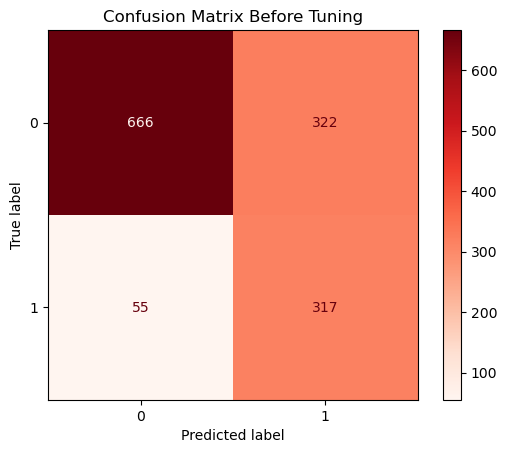

In [102]:
cm_before = confusion_matrix(y_test, y_pred_before)
cm_display_before = ConfusionMatrixDisplay(cm_before)
cm_display_before.plot(cmap='Reds');
plt.title('Confusion Matrix Before Tuning');

In [103]:
# Biaya-biaya
CRC = 139  # Cost of Retaining a Customer (Biaya Promosi per pelanggan)
CAC = 649  # Cost of Acquiring a Customer (Biaya Akuisisi pelanggan baru)

# Hasil Prediksi
TN, FP, FN, TP = cm_before.ravel()
# - TN = Pelanggan tidak churn dan diprediksi juga tidak churn
# - TP = Pelanggan churn dan diprediksi juga churn --> CRC
# - FN = Pelanggan churn tapi diprediksi tidak churn --> CAC
# - FP = Pelanggan tidak churn tapi diprediksi churn --> CRC

# --- Perhitungan ---

# 1. Biaya Promosi untuk Pelanggan TP
true_positive = TP * CRC

# 2. Biaya Akuisisi Pelanggan Baru akibat FN
false_negative = FN * CAC

# 3. Kerugian Promosi akibat FP
false_positive = FP * CRC

# 4. Total kerugian perusahaan
total_kerugian_before_tuning = true_positive + false_negative + false_positive


# --- Menampilkan Hasil ---
print("--- Menghitung Total Kerugian Dengan Model Prediktif (Sebelum Tuning) ---")
print("-" * 80)
print(f"   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)")
print(f"   = ${true_positive} + ${false_negative} + ${false_positive}")
print(f"   = ${total_kerugian_before_tuning}")
print("-" * 80)

--- Menghitung Total Kerugian Dengan Model Prediktif (Sebelum Tuning) ---
--------------------------------------------------------------------------------
   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)
   = $44063 + $35695 + $44758
   = $124516
--------------------------------------------------------------------------------


#### 3.5.3 After Tuning

In [104]:
best_model = gridsearch.best_estimator_

best_model.fit(X_train, y_train)

y_pred_after = best_model.predict(X_test)

f2_score_after = fbeta_score(y_test, y_pred_after, beta=2)

f2_score_after

0.7411764705882353

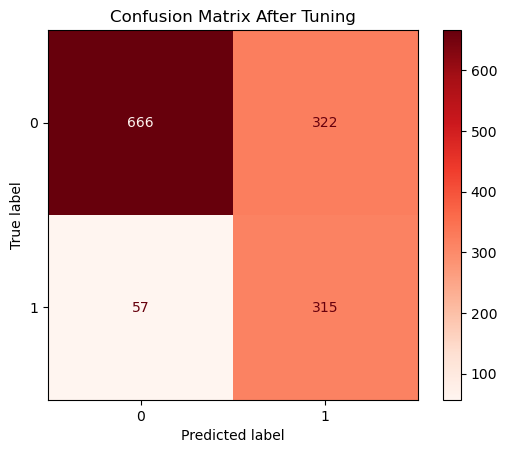

In [105]:
cm_after = confusion_matrix(y_test, y_pred_after)
cm_display_after = ConfusionMatrixDisplay(cm_after)
cm_display_after.plot(cmap='Reds');
plt.title('Confusion Matrix After Tuning');

In [106]:
# Biaya-biaya
CRC = 139  # Cost of Retaining a Customer (Biaya Promosi per pelanggan)
CAC = 649  # Cost of Acquiring a Customer (Biaya Akuisisi pelanggan baru)

# Hasil Prediksi
TN, FP, FN, TP = cm_after.ravel()
# - TN = Pelanggan tidak churn dan diprediksi juga tidak churn
# - TP = Pelanggan churn dan diprediksi juga churn --> CRC
# - FN = Pelanggan churn tapi diprediksi tidak churn --> CAC
# - FP = Pelanggan tidak churn tapi diprediksi churn --> CRC

# --- Perhitungan ---

# 1. Biaya Promosi untuk Pelanggan TP
true_positive = TP * CRC

# 2. Biaya Akuisisi Pelanggan Baru akibat FN
false_negative = FN * CAC

# 3. Kerugian Promosi akibat FP
false_positive = FP * CRC

# 4. Total kerugian perusahaan
total_kerugian_after_tuning = true_positive + false_negative + false_positive


# --- Menampilkan Hasil ---
print("--- Menghitung Total Kerugian Dengan Model Prediktif (Setelah Tuning) ---")
print("-" * 80)
print(f"   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)")
print(f"   = ${true_positive} + ${false_negative} + ${false_positive}")
print(f"   = ${total_kerugian_after_tuning}")
print("-" * 80)

--- Menghitung Total Kerugian Dengan Model Prediktif (Setelah Tuning) ---
--------------------------------------------------------------------------------
   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)
   = $43785 + $36993 + $44758
   = $125536
--------------------------------------------------------------------------------


In [107]:
df_kerugian = pd.DataFrame()
df_kerugian['Tanpa ML'] = [total_kerugian]
df_kerugian['Before Tuning'] = [total_kerugian_before_tuning]
df_kerugian['After Tuning'] = [total_kerugian_after_tuning]

In [108]:
df_f2score = pd.DataFrame()
df_f2score['Tanpa ML'] = [f2_score_tanpa_ml]
df_f2score['Before Tuning'] = [f2_score_before]
df_f2score['After Tuning'] = [f2_score_after]

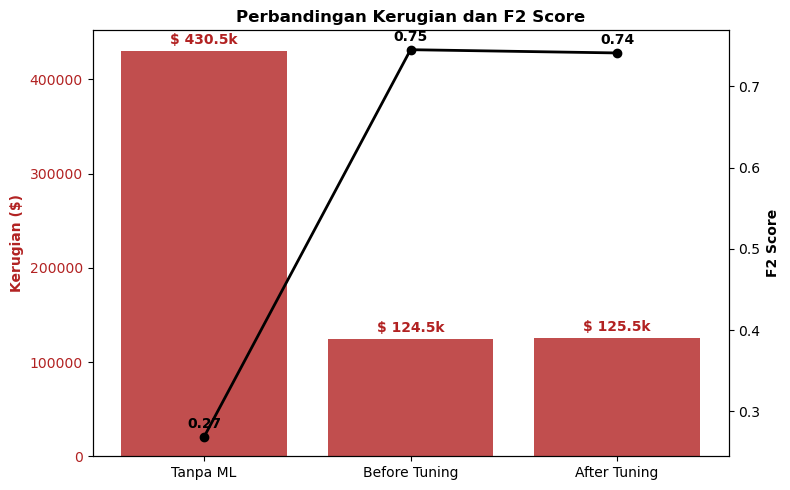

In [109]:
# Fungsi format singkat
def format_currency(val):
    if val >= 1_000_000:
        return f"$ {val/1_000_000:.1f}M"
    elif val >= 1_000:
        return f"$ {val/1_000:.1f}k"
    else:
        return f"$ {val}"

# Data
labels = df_kerugian.columns
kerugian_values = df_kerugian.iloc[0].values
f2_values = df_f2score.iloc[0].values

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(8,5))

# --- Bar Chart untuk Kerugian (firebrick) ---
ax1.bar(labels, kerugian_values, color='firebrick', alpha=0.8, label='Kerugian')
ax1.set_ylabel('Kerugian ($)', color='firebrick', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='firebrick')

# Tambahkan label nilai pada bar (pakai format singkat)
for i, v in enumerate(kerugian_values):
    ax1.text(i, v + (0.01 * max(kerugian_values)), format_currency(v), 
             ha='center', va='bottom', fontweight='bold', color='firebrick')

# --- Line Plot untuk F2 Score (black) ---
ax2 = ax1.twinx()
ax2.plot(labels, f2_values, color='black', marker='o', linewidth=2, label='F2 Score')
ax2.set_ylabel('F2 Score', color='black', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')

# Tambahkan label angka di tiap titik F2 Score
for i, v in enumerate(f2_values):
    ax2.text(i, v + (0.01 * max(f2_values)), f"{v:.2f}", 
             ha='center', va='bottom', fontweight='bold', color='black')

# Judul dan layout
plt.title('Perbandingan Kerugian dan F2 Score', fontweight='bold')
fig.tight_layout()
plt.show()

> Tanpa aplikasi machine learning, F2 score hanya sebesar 0.27 dan kerugian perusahaan sangat tinggi mencapai $430.5k. Kerugian yang sangat besar ini menunjukkan potensi ML untuk dapat menekan besaran kerugian.

> Aplikasi ML tanpa tuning menghasilkan F2 score yang meningkat menjadi 0.75 serta mampu menekan kerugian perusahaan menjadi $124.5k, 70% lebih rendah dibandingkan tanpa aplikasi ML.

> Setelah Tuning, F2 score sedikit menurun menjadi 0.74 serta kerugian perusahaan menjadi sedikit lebh besar dibandingkan tanpa tuning yakni sebesar $125.5k. Oleh karenanya, perlu dilakukan strategi lebih lanjut untuk mengevaluasi metrik kerugian perusahaan, salah satunya dengan pengaturan ulang threshold.

### 3.6 Threshold Probability Adjustment

In [110]:
# Menampilkan Prediksi dalam bentuk Probability
y_prediction_prob_after = best_model.predict_proba(X_test)[:,-1] #untuk fokus pada probability positive class (1)

In [111]:
# Membuat Precision-Recall Curve
precision_after, recall_after, threshold_after = precision_recall_curve(y_test, y_prediction_prob_after)

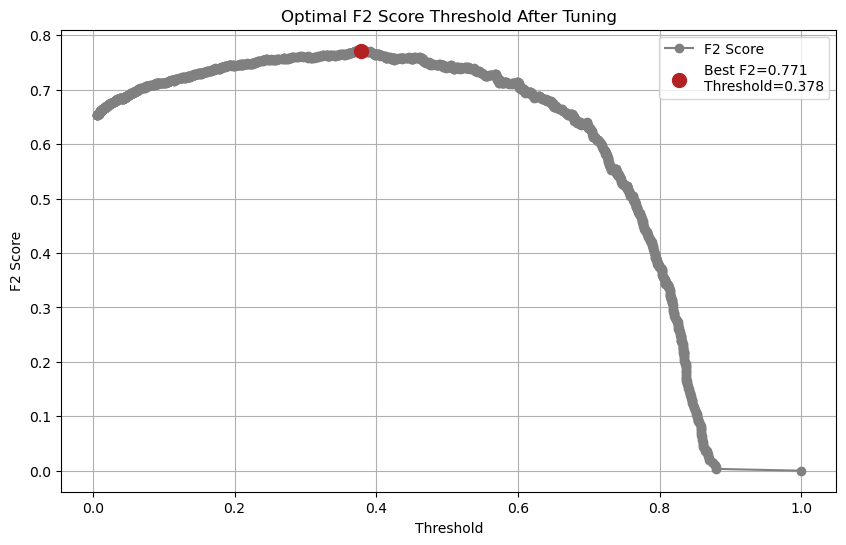

Best F2 Score: 0.7714 at Threshold: 0.3782


In [112]:
# Hitung F2 Score di setiap threshold
beta = 2
f2_scores_after = []
for p, r in zip(precision_after, recall_after):
    if p + r == 0:
        f2_after = 0
    else:
        f2_after = (1 + beta**2) * (p * r) / ((beta**2 * p) + r)
    f2_scores_after.append(f2_after)

# Potong thresholds biar sama panjang
thresholds_after = np.append(threshold_after, 1.0)  # PR curve thresholds panjangnya -1 dari precision/recall

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_after, f2_scores_after, marker='o', color='gray', label='F2 Score', zorder=3)
plt.title('Optimal F2 Score Threshold After Tuning')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.grid(True)

# Tandai threshold dengan F2 terbaik
best_idx_after = np.argmax(f2_scores_after)
best_threshold_after = thresholds_after[best_idx_after]
best_f2_after = f2_scores_after[best_idx_after]

plt.scatter(
    best_threshold_after, best_f2_after,
    color='firebrick', s=100,
    label=f'Best F2={best_f2_after:.3f}\nThreshold={best_threshold_after:.3f}',
    zorder=5)

plt.legend()
plt.show()

print(f'Best F2 Score: {best_f2_after:.4f} at Threshold: {best_threshold_after:.4f}')

In [113]:
# Membuat Threshold Baru
y_predict_newthreshold_after = (y_prediction_prob_after >= 0.3782).astype(int)
print(f'F2 Score Sebelumnya (Model After Tuning): {fbeta_score(y_test, y_pred_after, beta=2)}')
print(f'F2 Score (Model After Tuning): {fbeta_score(y_test, y_predict_newthreshold_after, beta=2)}')

f2_score_after_newthreshold = fbeta_score(y_test, y_predict_newthreshold_after, beta=2)

F2 Score Sebelumnya (Model After Tuning): 0.7411764705882353
F2 Score (Model After Tuning): 0.7695709862892526


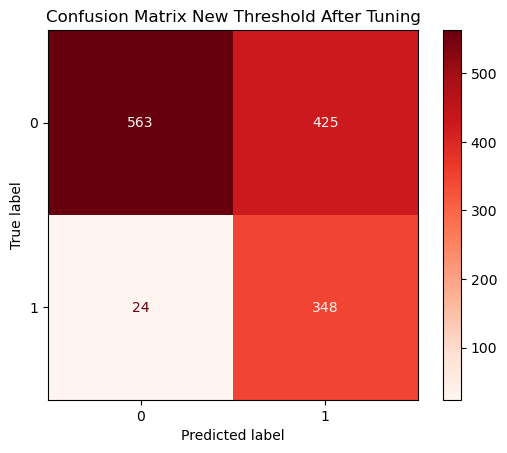

In [114]:
cm_newthreshold_after = confusion_matrix(y_test, y_predict_newthreshold_after)
cm_display_after = ConfusionMatrixDisplay(cm_newthreshold_after)
cm_display_after.plot(cmap='Reds');
plt.title('Confusion Matrix New Threshold After Tuning');

In [115]:
# Biaya-biaya
CRC = 139  # Cost of Retaining a Customer (Biaya Promosi per pelanggan)
CAC = 649  # Cost of Acquiring a Customer (Biaya Akuisisi pelanggan baru)

# Hasil Prediksi
TN, FP, FN, TP = cm_newthreshold_after.ravel()
# - TN = Pelanggan tidak churn dan diprediksi juga tidak churn
# - TP = Pelanggan churn dan diprediksi juga churn --> CRC
# - FN = Pelanggan churn tapi diprediksi tidak churn --> CAC
# - FP = Pelanggan tidak churn tapi diprediksi churn --> CRC

# --- Perhitungan ---

# 1. Biaya Promosi untuk Pelanggan TP
true_positive = TP * CRC

# 2. Biaya Akuisisi Pelanggan Baru akibat FN
false_negative = FN * CAC

# 3. Kerugian Promosi akibat FP
false_positive = FP * CRC

# 4. Total kerugian perusahaan
total_kerugian_after_tuning_newthreshold = true_positive + false_negative + false_positive


# --- Menampilkan Hasil ---
print("--- Menghitung Total Kerugian Dengan Threshold Baru (Setelah Tuning) ---")
print("-" * 80)
print(f"   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)")
print(f"   = ${true_positive} + ${false_negative} + ${false_positive}")
print(f"   = ${total_kerugian_after_tuning_newthreshold}")
print("-" * 80)

--- Menghitung Total Kerugian Dengan Threshold Baru (Setelah Tuning) ---
--------------------------------------------------------------------------------
   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)
   = $48372 + $15576 + $59075
   = $123023
--------------------------------------------------------------------------------


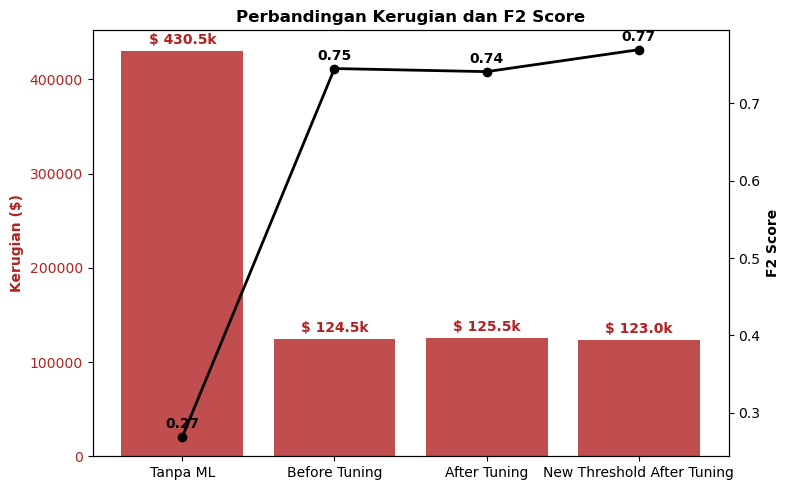

In [116]:
df_kerugian['New Threshold After Tuning'] = [total_kerugian_after_tuning_newthreshold]
df_f2score['New Threshold After Tuning'] = [f2_score_after_newthreshold]

# Fungsi format singkat
def format_currency(val):
    if val >= 1_000_000:
        return f"$ {val/1_000_000:.1f}M"
    elif val >= 1_000:
        return f"$ {val/1_000:.1f}k"
    else:
        return f"$ {val}"

# Data
labels = df_kerugian.columns
kerugian_values = df_kerugian.iloc[0].values
f2_values = df_f2score.iloc[0].values

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(8,5))

# --- Bar Chart untuk Kerugian (firebrick) ---
ax1.bar(labels, kerugian_values, color='firebrick', alpha=0.8, label='Kerugian')
ax1.set_ylabel('Kerugian ($)', color='firebrick', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='firebrick')

# Tambahkan label nilai pada bar (pakai format singkat)
for i, v in enumerate(kerugian_values):
    ax1.text(i, v + (0.01 * max(kerugian_values)), format_currency(v), 
             ha='center', va='bottom', fontweight='bold', color='firebrick')

# --- Line Plot untuk F2 Score (black) ---
ax2 = ax1.twinx()
ax2.plot(labels, f2_values, color='black', marker='o', linewidth=2, label='F2 Score')
ax2.set_ylabel('F2 Score', color='black', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')

# Tambahkan label angka di tiap titik F2 Score
for i, v in enumerate(f2_values):
    ax2.text(i, v + (0.01 * max(f2_values)), f"{v:.2f}", 
             ha='center', va='bottom', fontweight='bold', color='black')

# Judul dan layout
plt.title('Perbandingan Kerugian dan F2 Score', fontweight='bold')
fig.tight_layout()
plt.show()

> Setelah aplikasi ML yang telah dituning dan telah dilakukan penyesuaian threshold, perusahaan memperoleh F2 Score lebih tinggi (0.77) serta kerugian yang paling rendah dibandingkan metode lainnya yakni hanya sebesar $123k. Sehingga, akan dipilih model tersebut.

 >**Model Terpilih**
> 
> Model yang terpilih merupakan model yang memiliki spesifikasi sebagai berikut:
> 1. Model Logistic Regression
>   - Penalty = elasticnet
>   - Solver = saga
>   - C = 0.1
>   - l1_ratio = 0.9
> 2. Resampling menggunakan Borderline SMOTE
> 3. Threshold = 0.3782
> 4. F2 Score Test Set = 0.7695

### 3.7 Model Interpretation

#### 3.7.1 LLR Test (Model Significance)
- Hipotesis:
    + H0 : $\beta_i =  0$ (Tidak ada satupun fitur pada model yang berpengaruh signifikan terhadap target)  
    + H1 : $\beta_i \ne 0$ (Paling tidak ada 1 fitur yang berpengaruh kepada target)

In [117]:
y_train_num = y_train.astype(int)

probs_full = best_model.predict_proba(X_train)[:, 1]

# Cegah log(0)
eps = 1e-15
probs_full = np.clip(probs_full, eps, 1-eps)

LL_full = np.sum(y_train_num*np.log(probs_full) + (1-y_train_num)*np.log(1-probs_full))

# ===== Model null (hanya intercept) =====
logreg_null = LogisticRegression(fit_intercept=False, random_state=0)
X_null = np.ones((X_train.shape[0], 1))
logreg_null.fit(X_null, y_train_num)
probs_null = logreg_null.predict_proba(X_null)[:, 1]
probs_null = np.clip(probs_null, eps, 1-eps)

LL_null = np.sum(y_train_num*np.log(probs_null) + (1-y_train_num)*np.log(1-probs_null))

# ===== Hitung LLR =====
LLR = -2 * (LL_null - LL_full)
degree_of_freedom = best_model.named_steps['modeling'].n_features_in_  # degrees of freedom = jumlah feature
p_value = 1 - chi2.cdf(LLR, degree_of_freedom)

print("Log-Likelihood Full:", LL_full)
print("Log-Likelihood Null:", LL_null)
print("LLR Statistic:", LLR)
print("Degrees of Freedom:", degree_of_freedom)
print("p-value:", p_value)

Log-Likelihood Full: -2801.344728475721
Log-Likelihood Null: -3192.510348908362
LLR Statistic: 782.3312408652828
Degrees of Freedom: 30
p-value: 0.0


In [118]:
alpha = 0.05

if p_value > alpha:
    print("Gagal tolak H0")
    print("Tidak ada bukti signifikan bahwa fitur mempengaruhi target")
else:
    print("Tolak H0")
    print("Paling tidak ada 1 fitur yang berpengaruh signifikan terhadap target")

Tolak H0
Paling tidak ada 1 fitur yang berpengaruh signifikan terhadap target


> **Interpretasi LLR Test**
> - Model Full (dengan fitur) jauh lebih baik dibandingkan model Null (tanpa fitur).
> - Tolak H0, sehingga paling tidak ada satu variabel independen yang memberikan pengaruh signifikan terhadap target (churn).

#### 3.7.2 Wald Test (Variable Significance)
- Hipotesis:
    + H0 : $\beta_i =  0$ (Variabel i tidak berpengaruh pada target)
    + H1 : $\beta_i \ne 0$ (Variabel i berpengaruh signifikan pada target)

In [119]:
def wald_test_elasticnet(best_model, X_train, y_train, alpha=0.05):
    """
    Approximate Wald test untuk Logistic Regression dengan penalti elasticnet (saga).
    Catatan: inference ini hanya mendekati, karena L1 penalty membuat distribusi koefisien tidak normal.
    """

    # --- Ambil preprocessing dan model
    pre = best_model.named_steps['preprocessing']
    logreg = best_model.named_steps['modeling']

    # --- Transformasi X
    X = pre.transform(X_train)
    if not issparse(X):
        X = np.asarray(X)
    n = X.shape[0]

    # --- Tambah intercept
    if issparse(X):
        ones = csr_matrix(np.ones((n, 1)))
        X_aug = hstack([ones, X], format='csr')
    else:
        X_aug = np.column_stack([np.ones(n), X])

    # --- Nama fitur
    feature_names = np.concatenate([['Intercept'], pre.get_feature_names_out()])

    # --- Koefisien (gabung intercept + beta)
    beta_full = np.concatenate([logreg.intercept_.ravel(), logreg.coef_.ravel()])

    # --- Probabilitas prediksi
    p = best_model.predict_proba(X_train)[:, 1]
    p = np.clip(p, 1e-15, 1 - 1e-15)

    # --- Fisher Information tanpa L1
    W_vec = p * (1 - p)
    if issparse(X_aug):
        Xw = X_aug.multiply(W_vec[:, None])
        H = (X_aug.T @ Xw).toarray()
    else:
        H = X_aug.T @ (W_vec[:, None] * X_aug)

    # --- Tambahkan penalti L2 sesuai elasticnet
    lam = (1.0 / logreg.C) * (1 - logreg.l1_ratio)   # bobot ridge
    P = np.eye(H.shape[0])
    P[0, 0] = 0.0   # intercept tidak dipenalti
    H = H + lam * P

    # --- Kovarians approx
    cov = np.linalg.pinv(H)
    se = np.sqrt(np.clip(np.diag(cov), 0, np.inf))

    # --- Wald statistic & p-value
    z = beta_full / se
    wald_stat = z**2
    p_values = 1 - chi2.cdf(wald_stat, df=1)

    # --- Hasil ke DataFrame
    wald_df = pd.DataFrame({
        "Feature": feature_names,
        "Beta": beta_full,
        "StdErr": se,
        "WaldStat": wald_stat,
        "p_value": p_values
    })
    wald_df["Significance"] = np.where(
        wald_df["p_value"] < alpha,
        "Signifikan (Tolak H0)",
        "Tidak signifikan (Gagal tolak H0)"
    )

    return wald_df

# --- Contoh penggunaan:
wald_df = wald_test_elasticnet(best_model, X_train, y_train)
wald_df

,Feature,Beta,StdErr,WaldStat,p_value,Significance
0,Intercept,0.006074,0.892419,0.000046,9.945691e-01,Tidak signifikan (Gagal tolak H0)
1,onehot__gender_Male,-0.017706,0.067045,0.069748,7.917044e-01,Tidak signifikan (Gagal tolak H0)
2,onehot__SeniorCitizen_Yes,0.000000,0.092065,0.000000,1.000000e+00,Tidak signifikan (Gagal tolak H0)
3,onehot__Partner_Yes,0.000000,0.080632,0.000000,1.000000e+00,Tidak signifikan (Gagal tolak H0)
4,onehot__Dependents_Yes,-0.286539,0.088410,10.504318,1.190959e-03,Signifikan (Tolak H0)
5,onehot__PhoneService_Yes,-0.273171,0.725285,0.141858,7.064409e-01,Tidak signifikan (Gagal tolak H0)
6,onehot__MultipleLines_No phone service,0.271058,0.725285,0.139672,7.086076e-01,Tidak signifikan (Gagal tolak H0)
7,onehot__MultipleLines_Yes,0.024639,0.111143,0.049146,8.245561e-01,Tidak signifikan (Gagal tolak H0)
8,onehot__InternetService_Fiber optic,0.459086,0.377296,1.480550,2.236885e-01,Tidak signifikan (Gagal tolak H0)
9,onehot__InternetService_No,-0.101967,0.927505,0.012086,9.124597e-01,Tidak signifikan (Gagal tolak H0)


> Berdasarkan hasil wald test, fitur-fitur yang signifikan antara lain:
> - Dependents
> - OnlineSecurity
> - TechSupport
> - Contract
> - PaperlessBilling
> - tenure
> - TotalCharges

> Fitur yang tidak signifikan berkaitan dengan koefisien fitur. Kemungkinan, fitur-fitur yang tidak signifikan tersebut memiliki nilai koefisien yang sangat kecil sehingga tidak benar-benar mempengaruhi hasil prediksi dan model.

### 3.8 Feature Importances

In [120]:
best_model['preprocessing'].transformers_[0][1].get_feature_names_out()

array(['gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes',
       'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype=object)

In [121]:
best_model['preprocessing'].transformers_[1][1].get_feature_names_out()

array(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [122]:
col1 = list(best_model['preprocessing'].transformers_[0][1].get_feature_names_out())
col2 = list(best_model['preprocessing'].transformers_[1][1].get_feature_names_out())

all_col = col1 + col2

In [123]:
logreg = best_model.named_steps['modeling']

# Buat DataFrame feature importance
feature_importance = pd.DataFrame({
    'Feature': all_col,
    'Coefficient': logreg.coef_[0],               # koefisien logit
})

# Tambahkan kolom absolute coefficient & odds ratio
feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
feature_importance['Odds_Ratio'] = np.exp(feature_importance['Coefficient'])

# Urutkan berdasarkan pengaruh terbesar
feature_importance = feature_importance.sort_values(
    by='abs_coef', ascending=False
).reset_index(drop=True)

# Sajikan dalam bentuk tabel
feature_importance

,Feature,Coefficient,abs_coef,Odds_Ratio
0,tenure,-2.497662,2.497662,0.082277
1,Contract_Two year,-1.670945,1.670945,0.188069
2,TotalCharges,1.245303,1.245303,3.473988
3,Contract_One year,-0.743349,0.743349,0.475519
4,InternetService_Fiber optic,0.459086,0.459086,1.582627
5,TechSupport_Yes,-0.453001,0.453001,0.635718
6,OnlineSecurity_Yes,-0.424058,0.424058,0.654386
7,Dependents_Yes,-0.286539,0.286539,0.750858
8,PaperlessBilling_Yes,0.276530,0.276530,1.318546
9,PhoneService_Yes,-0.273171,0.273171,0.760962


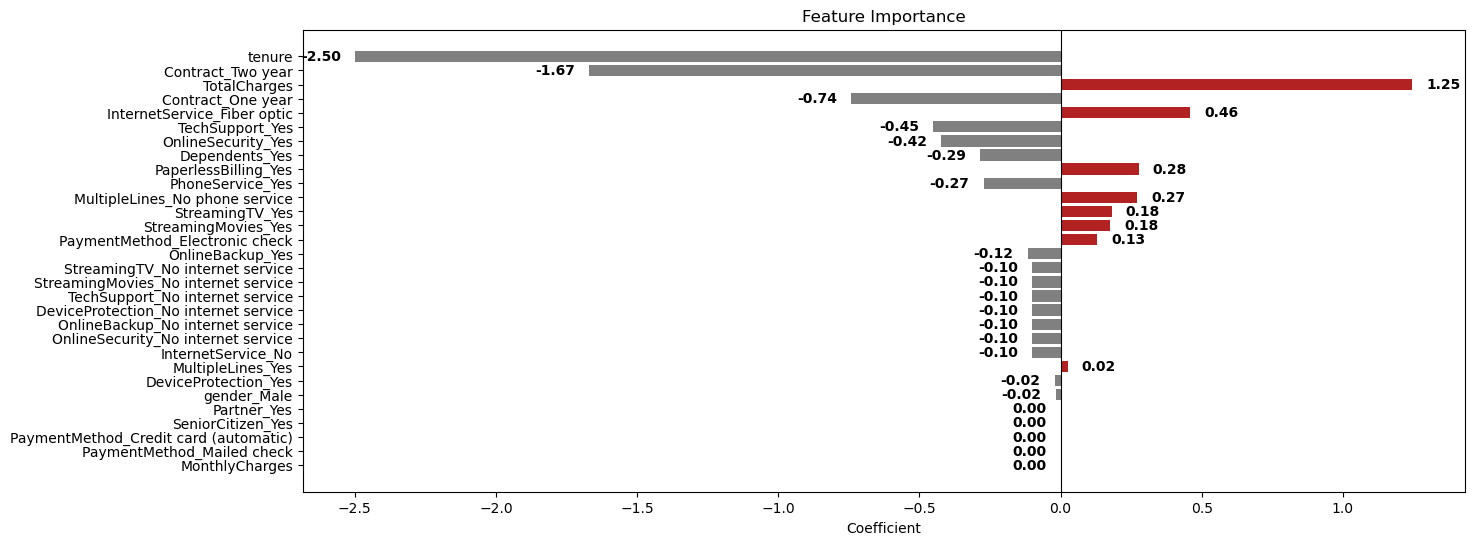

In [124]:
# Urutkan berdasarkan abs_coef dari besar ke kecil
df_sorted = feature_importance.sort_values("abs_coef", ascending=True)

plt.figure(figsize=(15, 6))
bars = plt.barh(
    df_sorted["Feature"],
    df_sorted["Coefficient"],
    color=["firebrick" if x > 0 else "gray" for x in df_sorted["Coefficient"]]
)

# Garis tengah (nol)
plt.axvline(x=0, color='black', linewidth=0.8)

# Tambahkan nilai koefisien di ujung bar
for bar, coef in zip(bars, df_sorted["Coefficient"]):
    plt.text(
        bar.get_width() + (0.05 if coef > 0 else -0.05),  # posisi teks
        bar.get_y() + bar.get_height()/2,                 # posisi di tengah bar
        f"{coef:.2f}",                                    # format angka
        va='center',
        ha='left' if coef > 0 else 'right',
        fontweight='bold'
    )

# Label sumbu
plt.xlabel("Coefficient")
plt.title("Feature Importance")

plt.show()

> Berdasarkan nilai koefisien, terdapat banyak fitur yang memiliki nilai koefisien < 1 atau sangat kecil. Oleh karenanya, akan dilakukan modeling ulang dengan menggunakan fitur-fitur yang signifikan terhadap model sesuai hasil wald test sebelumnya.

### 3.9 Remodeling dengan 7 Fitur Signifikan

#### 3.9.1 Define Feature and Target

In [126]:
X = df[['Dependents','tenure','OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'TotalCharges']]
y = df['Churn']

#### 3.9.2 Train-Test Split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

#### 3.9.3 Data Pre-Processing

In [128]:
transformer = ColumnTransformer([('onehot', 
                                  OneHotEncoder(drop='first'), 
                                  ['Dependents','OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling']),
                                   
                                   ('rbst',
                                    RobustScaler(), 
                                    ['tenure', 'TotalCharges'])],
                                    
                                   remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(drop='first'),
                                 ['Dependents', 'OnlineSecurity', 'TechSupport',
                                  'Contract', 'PaperlessBilling']),
                                ('rbst', RobustScaler(),
                                 ['tenure', 'TotalCharges'])])

#### 3.9.4 Multicolinearity Check

In [129]:
X_multiko = X.copy()
X_multiko = sm.add_constant(X_multiko)  # Menambahkan konstanta untuk intercept
X_multiko = X_multiko[['tenure', 'TotalCharges']]

vif_calc(X_multiko)

,Kolom,VIF,Acc
0,tenure,6.32045,Yes
1,TotalCharges,6.32045,Yes


> Hasil multiko cek model dengan 7 fitur (2 fitur numerik), semua fitur numeriknya tidak memiliki nilai VIF > 10 sehingga multikolinearitas nya sangat rendah.

#### 3.9.5 Hyperparameter Tuning
- Model Logistic Regression
- Resampling Borderline SMOTE

In [130]:
f2_score = make_scorer(fbeta_score, beta=2)
borderlinesmote = BorderlineSMOTE(sampling_strategy='minority', random_state=0)
logreg = LogisticRegression(random_state=0)

# Pipeline
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', borderlinesmote),
    ('modeling', logreg)
])

# hyperparam
hyperparam = [
    # L2 penalty
    {
        'modeling__penalty': ['l2'],
        'modeling__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],
        'modeling__C': [0.01, 0.1, 1, 10],
    },
    # L1 penalty
    {
        'modeling__penalty': ['l1'],
        'modeling__solver': ['liblinear', 'saga'],
        'modeling__C': [0.01, 0.1, 1, 10],
    },
    # Elasticnet penalty (saga only)
    {
        'modeling__penalty': ['elasticnet'],
        'modeling__solver': ['saga'],
        'modeling__C': [0.01, 0.1, 1, 10],
        'modeling__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    },
    # No penalty
    {
        'modeling__penalty': [None],
        'modeling__solver': ['lbfgs', 'saga', 'newton-cg'],
    }
]

# Randomized search
gridsearch = GridSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_grid = hyperparam,
    scoring = f2_score
)

In [131]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Dependents',
                                                                          'OnlineSecurity',
                                                                          'TechSupport',
                                                                          'Contract',
                                                                          'PaperlessBilling']),
                                                                        ('rbst',
                                                                         RobustScaler(),
                                                                         ['tenure',
                                                                          'TotalCharges'])])),
                                       ('resampling',
                                        BorderlineSMOTE(random_state=0,
                                                        sampling_strategy='m...
                          'modeling__penalty': ['l1'],
                          'modeling__solver': ['liblinear', 'saga']},
                         {'modeling__C': [0.01, 0.1, 1, 10],
                          'modeling__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'modeling__penalty': ['elasticnet'],
                          'modeling__solver': ['saga']},
                         {'modeling__penalty': [None],
                          'modeling__solver': ['lbfgs', 'saga', 'newton-cg']}],
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [132]:
gridsearch.best_score_

0.7383505681233584

In [133]:
gridsearch.best_params_

{'modeling__C': 1,
 'modeling__l1_ratio': 0.9,
 'modeling__penalty': 'elasticnet',
 'modeling__solver': 'saga'}

> Spesifikasi model sama antara model dengan fitur penuh (19 fitur) dengan model baru yang hanya menggunakan fitur signifikan (7 fitur)

#### 3.9.6 Predict to Test Set

In [139]:
best_model = gridsearch.best_estimator_

best_model.fit(X_train, y_train)

y_pred_after = best_model.predict(X_test)

f2_score_after = fbeta_score(y_test, y_pred_after, beta=2)

fbeta_score(y_test, y_pred_after, beta=2)

0.7406542056074766

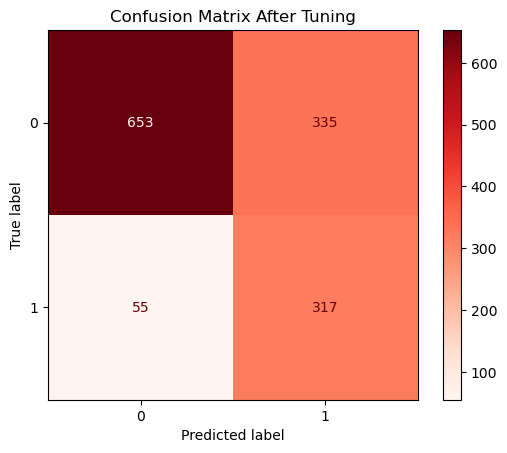

In [135]:
cm_after = confusion_matrix(y_test, y_pred_after)
cm_display_after = ConfusionMatrixDisplay(cm_after)
cm_display_after.plot(cmap='Reds');
plt.title('Confusion Matrix After Tuning');

In [137]:
# Biaya-biaya
CRC = 139  # Cost of Retaining a Customer (Biaya Promosi per pelanggan)
CAC = 649  # Cost of Acquiring a Customer (Biaya Akuisisi pelanggan baru)

# Hasil Prediksi
TN, FP, FN, TP = cm_after.ravel()
# - TN = Pelanggan tidak churn dan diprediksi juga tidak churn
# - TP = Pelanggan churn dan diprediksi juga churn --> CRC
# - FN = Pelanggan churn tapi diprediksi tidak churn --> CAC
# - FP = Pelanggan tidak churn tapi diprediksi churn --> CRC

# --- Perhitungan ---

# 1. Biaya Promosi untuk Pelanggan TP
true_positive = TP * CRC

# 2. Biaya Akuisisi Pelanggan Baru akibat FN
false_negative = FN * CAC

# 3. Kerugian Promosi akibat FP
false_positive = FP * CRC

# 4. Total kerugian perusahaan
total_kerugian_after_tuning = true_positive + false_negative + false_positive


# --- Menampilkan Hasil ---
print("--- Menghitung Total Kerugian Dengan Model Prediktif 7 Fitur (Setelah Tuning) ---")
print("-" * 80)
print(f"   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)")
print(f"   = ${true_positive} + ${false_negative} + ${false_positive}")
print(f"   = ${total_kerugian_after_tuning}")
print("-" * 80)

--- Menghitung Total Kerugian Dengan Model Prediktif 7 Fitur (Setelah Tuning) ---
--------------------------------------------------------------------------------
   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)
   = $44063 + $35695 + $46565
   = $126323
--------------------------------------------------------------------------------


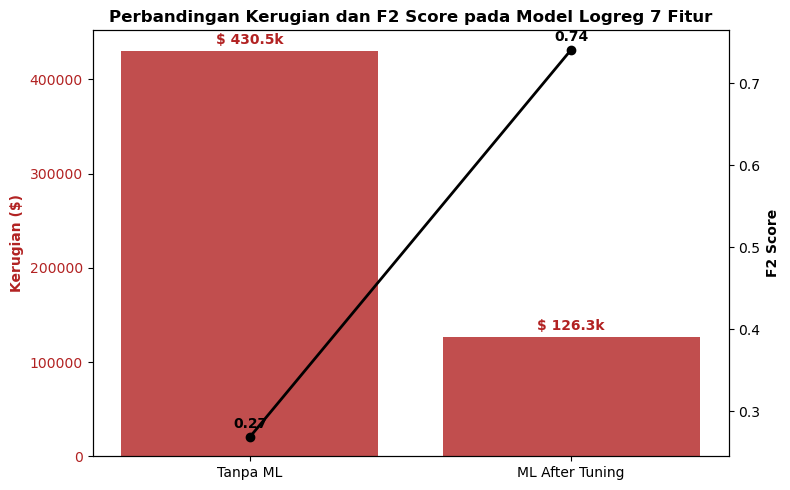

In [ ]:
df_kerugian = pd.DataFrame()
df_kerugian['Tanpa ML'] = [total_kerugian]
df_kerugian['After Tuning'] = [total_kerugian_after_tuning]

df_f2score = pd.DataFrame()
df_f2score['Tanpa ML'] = [f2_score_tanpa_ml]
df_f2score['After Tuning'] = [f2_score_after]

# Fungsi format singkat
def format_currency(val):
    if val >= 1_000_000:
        return f"$ {val/1_000_000:.1f}M"
    elif val >= 1_000:
        return f"$ {val/1_000:.1f}k"
    else:
        return f"$ {val}"

# Data
labels = df_kerugian.columns
kerugian_values = df_kerugian.iloc[0].values
f2_values = df_f2score.iloc[0].values

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(8,5))

# --- Bar Chart untuk Kerugian (firebrick) ---
ax1.bar(labels, kerugian_values, color='firebrick', alpha=0.8, label='Kerugian')
ax1.set_ylabel('Kerugian ($)', color='firebrick', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='firebrick')

# Tambahkan label nilai pada bar (pakai format singkat)
for i, v in enumerate(kerugian_values):
    ax1.text(i, v + (0.01 * max(kerugian_values)), format_currency(v), 
             ha='center', va='bottom', fontweight='bold', color='firebrick')

# --- Line Plot untuk F2 Score (black) ---
ax2 = ax1.twinx()
ax2.plot(labels, f2_values, color='black', marker='o', linewidth=2, label='F2 Score')
ax2.set_ylabel('F2 Score', color='black', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')

# Tambahkan label angka di tiap titik F2 Score
for i, v in enumerate(f2_values):
    ax2.text(i, v + (0.01 * max(f2_values)), f"{v:.2f}", 
             ha='center', va='bottom', fontweight='bold', color='black')

# Judul dan layout
plt.title('Perbandingan Kerugian dan F2 Score pada Model Logreg 7 Fitur', fontweight='bold')
fig.tight_layout()
plt.show()

#### 3.9.7 Threshold Probability Adjustment

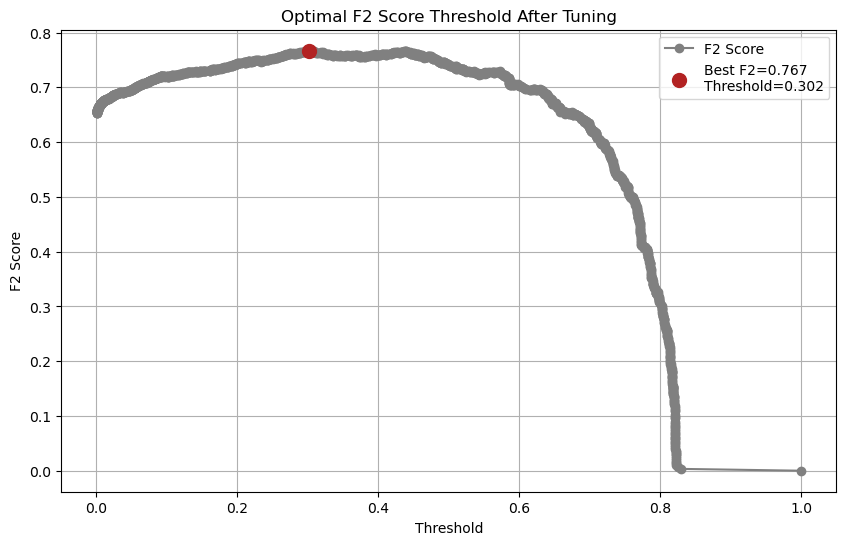

Best F2 Score: 0.7668 at Threshold: 0.3023


In [142]:
# Menampilkan Prediksi dalam bentuk Probability
y_prediction_prob_after = best_model.predict_proba(X_test)[:,-1] #untuk fokus pada probability positive class (1)

# Membuat Precision-Recall Curve
precision_after, recall_after, threshold_after = precision_recall_curve(y_test, y_prediction_prob_after)

# Hitung F2 Score di setiap threshold
beta = 2
f2_scores_after = []
for p, r in zip(precision_after, recall_after):
    if p + r == 0:
        f2_after = 0
    else:
        f2_after = (1 + beta**2) * (p * r) / ((beta**2 * p) + r)
    f2_scores_after.append(f2_after)

# Potong thresholds biar sama panjang
thresholds_after = np.append(threshold_after, 1.0)  # PR curve thresholds panjangnya -1 dari precision/recall

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_after, f2_scores_after, marker='o', color='gray', label='F2 Score', zorder=3)
plt.title('Optimal F2 Score Threshold After Tuning')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.grid(True)

# Tandai threshold dengan F2 terbaik
best_idx_after = np.argmax(f2_scores_after)
best_threshold_after = thresholds_after[best_idx_after]
best_f2_after = f2_scores_after[best_idx_after]

plt.scatter(
    best_threshold_after, best_f2_after,
    color='firebrick', s=100,
    label=f'Best F2={best_f2_after:.3f}\nThreshold={best_threshold_after:.3f}',
    zorder=5)

plt.legend()
plt.show()

print(f'Best F2 Score: {best_f2_after:.4f} at Threshold: {best_threshold_after:.4f}')

In [143]:
# Membuat Threshold Baru
y_predict_newthreshold_after = (y_prediction_prob_after >= 0.3023).astype(int)
f2_score_after_newthreshold = fbeta_score(y_test, y_predict_newthreshold_after, beta=2)
print(f'F2 Score Sebelumnya (Model After Tuning): {fbeta_score(y_test, y_pred_after, beta=2)}')
print(f'F2 Score (Model After Tuning): {fbeta_score(y_test, y_predict_newthreshold_after, beta=2)}')

F2 Score Sebelumnya (Model After Tuning): 0.7406542056074766
F2 Score (Model After Tuning): 0.7649333906317146


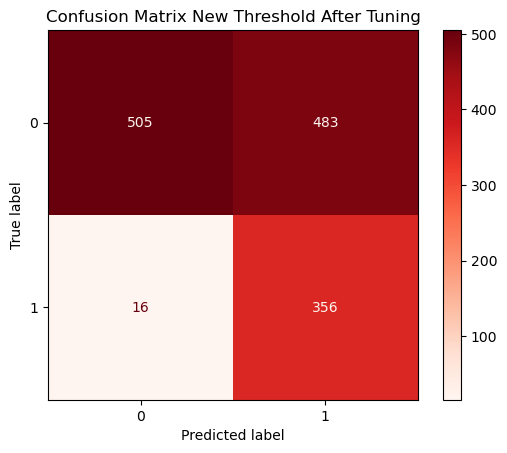

In [144]:
cm_newthreshold_after = confusion_matrix(y_test, y_predict_newthreshold_after)
cm_display_after = ConfusionMatrixDisplay(cm_newthreshold_after)
cm_display_after.plot(cmap='Reds');
plt.title('Confusion Matrix New Threshold After Tuning');

In [145]:
# Biaya-biaya
CRC = 139  # Cost of Retaining a Customer (Biaya Promosi per pelanggan)
CAC = 649  # Cost of Acquiring a Customer (Biaya Akuisisi pelanggan baru)

# Hasil Prediksi
TN, FP, FN, TP = cm_newthreshold_after.ravel()
# - TN = Pelanggan tidak churn dan diprediksi juga tidak churn
# - TP = Pelanggan churn dan diprediksi juga churn --> CRC
# - FN = Pelanggan churn tapi diprediksi tidak churn --> CAC
# - FP = Pelanggan tidak churn tapi diprediksi churn --> CRC

# --- Perhitungan ---

# 1. Biaya Promosi untuk Pelanggan TP
true_positive = TP * CRC

# 2. Biaya Akuisisi Pelanggan Baru akibat FN
false_negative = FN * CAC

# 3. Kerugian Promosi akibat FP
false_positive = FP * CRC

# 4. Total kerugian perusahaan
total_kerugian_after_tuning_newthreshold = true_positive + false_negative + false_positive


# --- Menampilkan Hasil ---
print("--- Menghitung Total Kerugian Dengan Threshold Baru (Setelah Tuning) ---")
print("-" * 80)
print(f"   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)")
print(f"   = ${true_positive} + ${false_negative} + ${false_positive}")
print(f"   = ${total_kerugian_after_tuning_newthreshold}")
print("-" * 80)

--- Menghitung Total Kerugian Dengan Threshold Baru (Setelah Tuning) ---
--------------------------------------------------------------------------------
   = Biaya Promosi (TP) + Biaya Akuisisi (FN) + Kerugian Promosi (FP)
   = $49484 + $10384 + $67137
   = $127005
--------------------------------------------------------------------------------


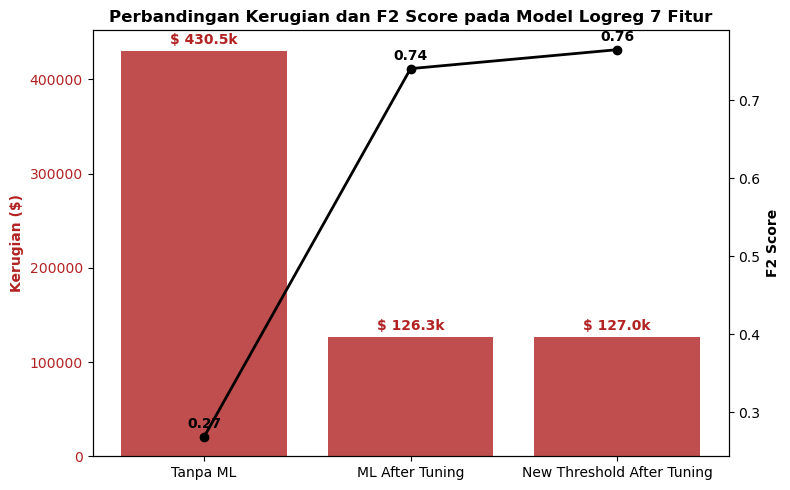

In [146]:
df_kerugian['New Threshold After Tuning'] = [total_kerugian_after_tuning_newthreshold]
df_f2score['New Threshold After Tuning'] = [f2_score_after_newthreshold]

# Fungsi format singkat
def format_currency(val):
    if val >= 1_000_000:
        return f"$ {val/1_000_000:.1f}M"
    elif val >= 1_000:
        return f"$ {val/1_000:.1f}k"
    else:
        return f"$ {val}"

# Data
labels = df_kerugian.columns
kerugian_values = df_kerugian.iloc[0].values
f2_values = df_f2score.iloc[0].values

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(8,5))

# --- Bar Chart untuk Kerugian (firebrick) ---
ax1.bar(labels, kerugian_values, color='firebrick', alpha=0.8, label='Kerugian')
ax1.set_ylabel('Kerugian ($)', color='firebrick', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='firebrick')

# Tambahkan label nilai pada bar (pakai format singkat)
for i, v in enumerate(kerugian_values):
    ax1.text(i, v + (0.01 * max(kerugian_values)), format_currency(v), 
             ha='center', va='bottom', fontweight='bold', color='firebrick')

# --- Line Plot untuk F2 Score (black) ---
ax2 = ax1.twinx()
ax2.plot(labels, f2_values, color='black', marker='o', linewidth=2, label='F2 Score')
ax2.set_ylabel('F2 Score', color='black', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')

# Tambahkan label angka di tiap titik F2 Score
for i, v in enumerate(f2_values):
    ax2.text(i, v + (0.01 * max(f2_values)), f"{v:.2f}", 
             ha='center', va='bottom', fontweight='bold', color='black')

# Judul dan layout
plt.title('Perbandingan Kerugian dan F2 Score pada Model Logreg 7 Fitur', fontweight='bold')
fig.tight_layout()
plt.show()

> **Interpretasi:**
> - Penerapan model Logistic Regression dengan tuning berhasil menurunkan kerugian dari $430k menjadi $126.3k. F2 Score meningkat dari 0.27 menjadi 0.74, menunjukkan model lebih baik dalam mendeteksi target positif dengan mempertimbangkan recall.
> - Threshold adjustment hanya memberi perbaikan kecil di F2 Score (naik menjadi 0.76) tanpa perubahan signifikan pada kerugian.

#### 3.9.8 Feature Importances

In [147]:
best_model['preprocessing'].transformers_[0][1].get_feature_names_out()

array(['Dependents_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes'], dtype=object)

In [148]:
best_model['preprocessing'].transformers_[1][1].get_feature_names_out()

array(['tenure', 'TotalCharges'], dtype=object)

In [149]:
col1 = list(best_model['preprocessing'].transformers_[0][1].get_feature_names_out())
col2 = list(best_model['preprocessing'].transformers_[1][1].get_feature_names_out())

all_col = col1 + col2

In [150]:
logreg = best_model.named_steps['modeling']

# Buat DataFrame feature importance
feature_importance = pd.DataFrame({
    'Feature': all_col,
    'Coefficient': logreg.coef_[0],               # koefisien logit
})

# Tambahkan kolom absolute coefficient & odds ratio
feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
feature_importance['Odds_Ratio'] = np.exp(feature_importance['Coefficient'])

# Urutkan berdasarkan pengaruh terbesar
feature_importance = feature_importance.sort_values(
    by='abs_coef', ascending=False
).reset_index(drop=True)

# Sajikan dalam bentuk tabel
feature_importance

,Feature,Coefficient,abs_coef,Odds_Ratio
0,tenure,-3.583103,3.583103,0.027789
1,TotalCharges,2.361255,2.361255,10.604252
2,Contract_Two year,-2.057280,2.057280,0.127801
3,Contract_One year,-0.946266,0.946266,0.388188
4,OnlineSecurity_No internet service,-0.571034,0.571034,0.564941
5,TechSupport_No internet service,-0.571034,0.571034,0.564941
6,OnlineSecurity_Yes,-0.502245,0.502245,0.605170
7,TechSupport_Yes,-0.377706,0.377706,0.685432
8,PaperlessBilling_Yes,0.304296,0.304296,1.355671
9,Dependents_Yes,-0.212206,0.212206,0.808798


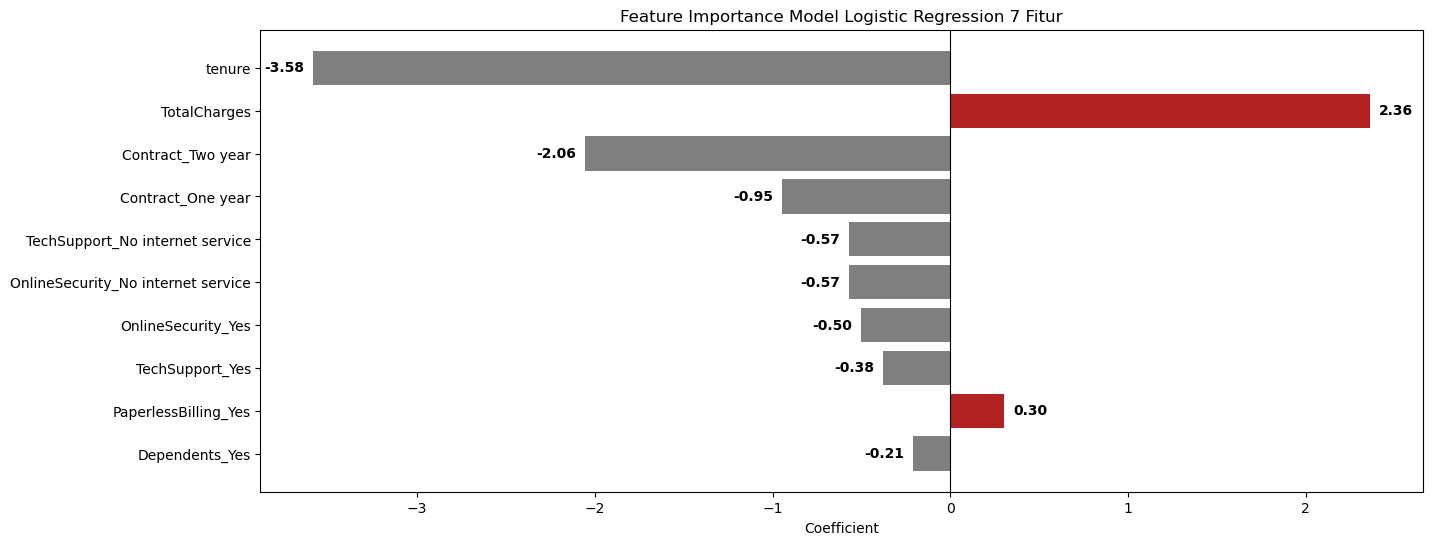

In [152]:
# Urutkan berdasarkan abs_coef dari besar ke kecil
df_sorted = feature_importance.sort_values("abs_coef", ascending=True)

plt.figure(figsize=(15, 6))
bars = plt.barh(
    df_sorted["Feature"],
    df_sorted["Coefficient"],
    color=["firebrick" if x > 0 else "gray" for x in df_sorted["Coefficient"]]
)

# Garis tengah (nol)
plt.axvline(x=0, color='black', linewidth=0.8)

# Tambahkan nilai koefisien di ujung bar
for bar, coef in zip(bars, df_sorted["Coefficient"]):
    plt.text(
        bar.get_width() + (0.05 if coef > 0 else -0.05),  # posisi teks
        bar.get_y() + bar.get_height()/2,                 # posisi di tengah bar
        f"{coef:.2f}",                                    # format angka
        va='center',
        ha='left' if coef > 0 else 'right',
        fontweight='bold'
    )

# Label sumbu
plt.xlabel("Coefficient")
plt.title("Feature Importance Model Logistic Regression 7 Fitur")

plt.show()

**Interpretasi Fitur-fitur dalam Model**
1. `tenure`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, semakin besar nilai tenure, maka kemungkinan seorang pelanggan menjadi Churn lebih rendah.
    - Odds Ratio = 0.0277. Artinya, setiap kenaikna 1 unit tenure, maka odds pelanggan menjadi Churn sebesar 0.0277 kali dibanding sebelumnya (menurun).

2. `TotalCharges`
    - Koefisien positif menunjukkan arah hubungan yang berbanding lurus. Artinya, semakin besar TotalCharges yang dibayarkan oleh pelanggan, maka kemungkinan pelanggan menjadi Churn semakin tinggi.
    - Odds Ratio = 10.604. Artinya, setiap kenaikan 1 unit TotalCharges, maka odds pelanggan menjadi Churn sebesar 10.604 kali lipat dari sebelumnya (meningkat).

3. `Contract_TwoYear`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan dengan kontrak 2 tahun (Two Year), kemungkinan untuk Churn lebih rendah dibandingkan pelanggan dengan kontrak bulanan (month-to-month/baseline).
    - Odds Ratio = 0.1278. Artinya, pelanggan dengan kontrak 2 tahun (Two Year) odds Churn nya sebesar 0.1278 kali dari pelanggan yang kontraknya bulanan (month-to-month/baseline)(menurun).

4. `Contract_OneYear`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan dengan kontrak tahunan (One Year), kemungkinan untuk Churn lebih rendah dibandingkan pelanggan dengan kontrak bulanan (month-to-month/baseline).
    - Odds Ratio = 0.3881. Artinya, pelanggan dengan kontrak tahunan (One Year) odds Churn nya sebesar 0.3881 kali dari pelanggan yang kontraknya bulanan (month-to-month/baseline)(menurun).

5. `OnlineSecurity_No internet service`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan yang tidak menggunakan layanan internet service sehingga tidak menggunakan layanan OnlineSecurity, kemungkinan untuk Churn lebih rendah dibandingkan pelanggan yang menggunakan layanan internet service namun tidak menggunakan layanan OnlineSecurity (baseline).
    - Odds Ratio = 0.5649. Artinya, pelanggan yang tidak menggunakan layanan internet service sehingga tidak menggunakan layanan OnlineSecurity odds Churn nya sebesar 0.5649 kali dari pelanggan yang menggunakan layanan internet service namun tidak menggunakan layanan OnlineSecurity (menurun).

6. `TechSupport_No internet service`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan yang tidak menggunakan layanan internet service sehingga tidak menggunakan layanan TechSupport, kemungkinan untuk Churn lebih rendah dibandingkan pelanggan yang menggunakan layanan internet service namun tidak menggunakan layanan TechSupport (baseline).
    - Odds Ratio = 0.5649. Artinya, pelanggan yang tidak menggunakan layanan internet service sehingga tidak menggunakan layanan TechSupport odds Churn nya sebesar 0.5649 kali dari pelanggan yang menggunakan layanan internet service namun tidak menggunakan layanan TechSupport (baseline) (menurun).

7. `OnlineSecurity_Yes`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan yang menggunakan layanan OnlineSecurity, kemungkinan untuk Churn lebih rendah dibandingkan pelanggan yang tidak menggunakan layanan OnlineSecurity (baseline).
    - Odds Ratio = 0.6051. Artinya, pelanggan yang menggunakan layanan OnlineSecurity odds Churn nya sebesar 0.6051 kali dari pelanggan yang tidak menggunakan layanan OnlineSecurity (baseline) (menurun).

8. `TechSupport_Yes`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan yang menggunakan layanan TechSupport, kemungkinan untuk Churn lebih rendah dibandingkan pelanggan yang tidak menggunakan layanan TechSupport (baseline).
    - Odds Ratio = 0.6854. Artinya, pelanggan yang menggunakan layanan TechSupport odds Churn nya sebesar 0.6854 kali dari pelanggan yang tidak menggunakan layanan TechSupport (baseline) (menurun).

9. `PaperlessBilling_Yes`
    - Koefisien positif menunjukkan arah hubungan yang berbanding lurus. Artinya, pelanggan yang tidak menggunakan tagihan kertas (paperless), kemungkinan untuk Churn lebih tinggi dibandingkan dengan pelanggan yang menggunakan tagihan kertas (baseline).
    - Odds Ratio = 1.3556. Artinya, pelanggan yang tidak menggunakan tagihan kertas (paperless) odds Churn nya sebesar 1.3556 kali dari pelanggan yang menggunakan tagihan kertas (meningkat).

10. `Dependents_Yes`
    - Koefisien negatif menunjukkan arah hubungan yang berbanding terbalik. Artinya, pelanggan yang memiliki tanggungan (Dependents), kemungkinan untuk Churn lebih rendah dibanding pelanggan yang tidak memiliki tanggungan (baseline).
    - Odds Ratio = 0.8087. Artinya, pelanggan yang memiliki tanggungan (Dependents) odds Churn nya sebesar 0.8087 kali dari pelanggan yang tidak memiliki tanggungan (menurun).

### 3.10 Limitasi Model
1. Keterbatasan Fitur
    - Model hanya menggunakan fitur yang tersedia dalam dataset. Faktor penting lain yang mungkin memengaruhi target (misalnya alasan churn, lokasi pelanggan, jumlah penggunaan internet, dan sebaginya) tidak terwakili.
2. Model melatih data numerik dalam range sesuai pada dataset. Apabila dikemudian hari data numerik seperti tenure dan total charges yang diinput nilainya kurang dari atau lebih dari range yang digunakan dalam pelatihan model, maka model tidak dapat memprediksi Churn secara akurat.
3. Model yang dibangun merupakan model klasifikasi biner (Churn dan Not Churn). Sehingga, tidak dapat mengukur tingkat keparahan yang lebih detil.

### 3.11 Saving Model

#### 3.11.1 Pickle

In [155]:
# Best Model
logreg_tuning_threshold = gridsearch.best_estimator_

# Fit
logreg_tuning_threshold.fit(X, y)

# Save with pickle
with open('../Model/Model_LogReg_7_Fitur_Telco_Churn.sav', 'wb') as model_file:
    pickle.dump({
        'model': logreg_tuning_threshold,
        'threshold': 0.3023
    }, model_file)

#### 3.11.2 Joblib

In [156]:
# Best Model
logreg_tuning_threshold_joblib = gridsearch.best_estimator_

# Fit
logreg_tuning_threshold_joblib.fit(X, y)

# Save with joblib
joblib.dump(
    {
        'model': logreg_tuning_threshold_joblib,
        'threshold': 0.3023
    },
    '../Model/Model_Logreg_7_fitur_Telco_Churn_joblib.pkl'
)

['../Model/Model_Logreg_7_fitur_Telco_Churn_joblib.pkl']

### 3.10 Conclusion
Berdasarkan pembangunan dan analisa model machine learning yang dilakukan, dapat ditarik beberapa kesimpulan sebagai berikut:
1. Aplikasi model Machine Learning efektif menekan kerugian perusahaan mencapai 70%.
    - Tanpa ML, kerugian perusahaan sebesar $430k.
    - Aplikasi ML dengan model Logistic Regression 7 fitur yang telah dituning dan diatur threshold optimalnya, kerugian perusahaan sebesar $126k.
2. Model Interpretation:
    - Hasil LLR test pada model dengan 19 fitur (full) memiliki p-value sebesar 0.0 yang artinya paling tidak terdapat 1 fitur yang berpengaruh signifikan terhadap target.
    - Hasil wald test pada model dengan 19 fitur (full) menyatakan bahwa, dari 19 fitur yang digunakan, hanya 7 fitur yang signifikan terhadap target antara lain Dependents, OnlineSecurity, TechSupport, Contract, PaperlessBilling, tenure, dan TotalCharges.
3. Faktor-faktor penting dalam menentukan Churn pelanggan antara lain:
    - Tenure (lama berlangganan). Semakin lama pelanggan bertahan, resiko churn nya semakin rendah.
    - Total Charges (total tagihan). Semakin tinggi biaya total yang dibayarkan pelanggan, semakin tinggi resiko churn nya.
    - Jenis kontrak. Kontrak jangka panjang (1/2 tahun) secara signifikan menurunkan resiko churn dibandingkan kontrak jangka pendek (bulanan).
    - Layanan tambahan seperti online security dan tech support menurunkan resiko churn.
4. Rekomendasi bisnis yang dapat diberikan antara lain sebagai berikut:
    - Berikan program retensi bagi pelanggan baru seperti promo bundling 3 bulan, diskon, dan loyalty point untuk mempertahankan pelanggan lebih lama.
    - Dorong pelanggan pada kontrak jangka panjang dengan memberikan harga yang lebih murah dibandingkan kontrak janga pendek, sejumlah fitur tambahan gratis jika mengambi kontrak janga panjang, atau insentif lainnya bila mengambil kontrak panjang.
    - Promosikan layanan tambahan dengan membuat promo bundling dengan paket utama.
    - Pelanggan dengan keluarga atau tanggungan lebih tidak beresiko churn, sehingga fokuskan target pada segmen tersebut. Bisa berikan promo family bundling, dan sebagainya.